In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression



In [338]:
#Load data
full_data = pd.read_csv("Life Expectancy Data.csv")
full_data.info()
cols = ["Life expectancy", "Status", "Alcohol", "GDP", "BMI", "Schooling"]
                   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [339]:
#Clean data
full_data.columns = full_data.columns.str.strip()
data = full_data[cols].dropna() 

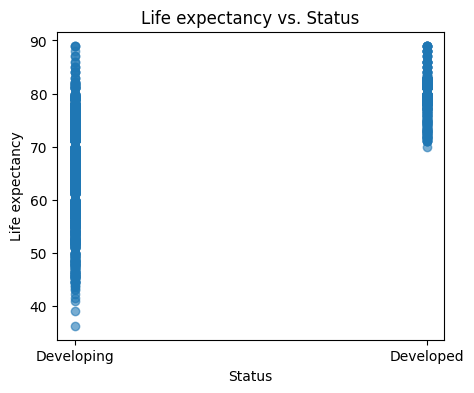

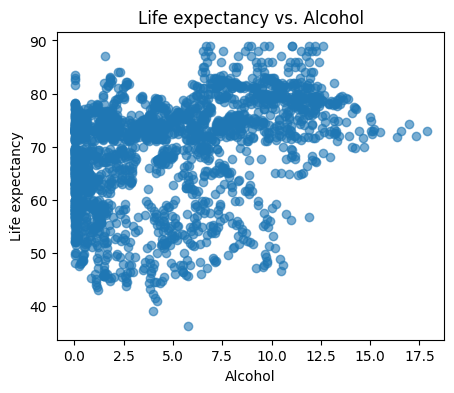

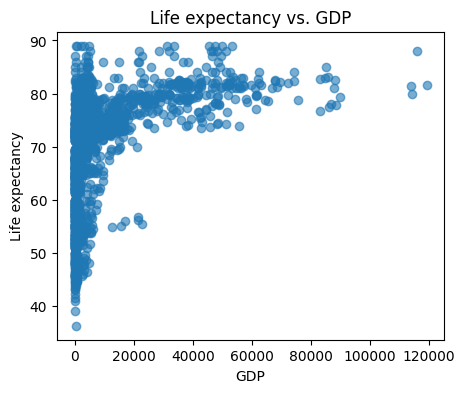

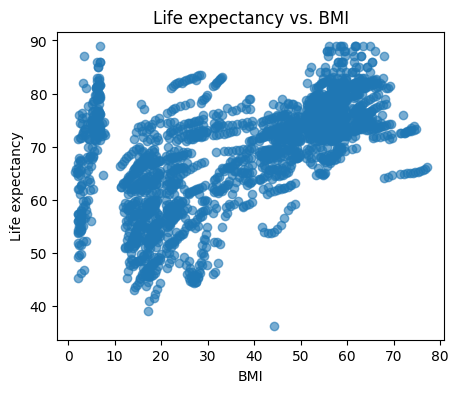

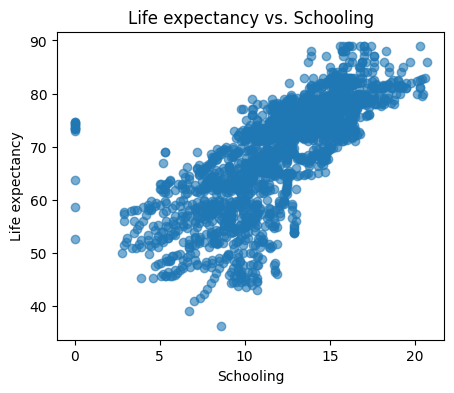

In [340]:
#Ceck predictor vs. response plots
response = cols[0]
predictors = cols[1:]
for col in predictors:
    plt.figure(figsize=(5,4))
    plt.scatter(data[col], data[response], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel(response)
    plt.title(f"{response} vs. {col}")
    plt.show()

In [341]:
#I notice that there are many "streaks" in the BMI vs life expectancy plot where a few points look to be correlated.
#This is likely due to the fact that many of these data points are the same country, evaluated at different calendar years.
#lets look to see how many data points we have for each country
print(f"Number of years of data per country: \n{full_data["Country"].value_counts()}\n")
print(f"Number of data points per year: \n{full_data["Year"].value_counts()}")

Number of years of data per country: 
Country
Afghanistan              16
Albania                  16
Algeria                  16
Angola                   16
Antigua and Barbuda      16
                         ..
Monaco                    1
Marshall Islands          1
Saint Kitts and Nevis     1
San Marino                1
Tuvalu                    1
Name: count, Length: 193, dtype: int64

Number of data points per year: 
Year
2013    193
2015    183
2014    183
2012    183
2011    183
2010    183
2009    183
2008    183
2007    183
2006    183
2005    183
2004    183
2003    183
2002    183
2001    183
2000    183
Name: count, dtype: int64


In [342]:
#Because any two data points for the same country are not independent of each other, 
# they will violate the assumption of our linear model that errors are independent.
# Lets look to see which calendar year to use based on the available data.
full_data.groupby("Year")[cols].count()


,Life expectancy,Status,Alcohol,GDP,BMI,Schooling
Year,,,,,,
2000,183,183,182,154,181,173
2001,183,183,182,155,181,173
2002,183,183,182,155,181,173
2003,183,183,182,155,181,173
2004,183,183,182,156,181,173
2005,183,183,181,156,181,173
2006,183,183,182,156,181,173
2007,183,183,182,156,181,173
2008,183,183,182,156,181,173


In [343]:
#Since 2015 only contains 6 data points for alcohol, lets use 2014.
full_data = full_data[full_data["Year"] == 2014]
full_data.columns = full_data.columns.str.strip()

#Load the updated datasets
data = full_data[cols].dropna()
data2 = data.copy()
data2 = pd.get_dummies(data2, columns=['Status'], drop_first=True)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 2923
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          183 non-null    object 
 1   Year                             183 non-null    int64  
 2   Status                           183 non-null    object 
 3   Life expectancy                  183 non-null    float64
 4   Adult Mortality                  183 non-null    float64
 5   infant deaths                    183 non-null    int64  
 6   Alcohol                          182 non-null    float64
 7   percentage expenditure           183 non-null    float64
 8   Hepatitis B                      173 non-null    float64
 9   Measles                          183 non-null    int64  
 10  BMI                              181 non-null    float64
 11  under-five deaths                183 non-null    int64  
 12  Polio                     

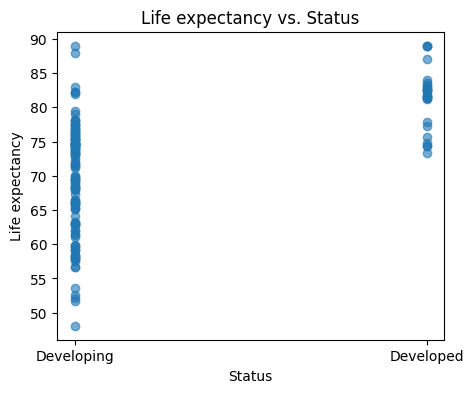

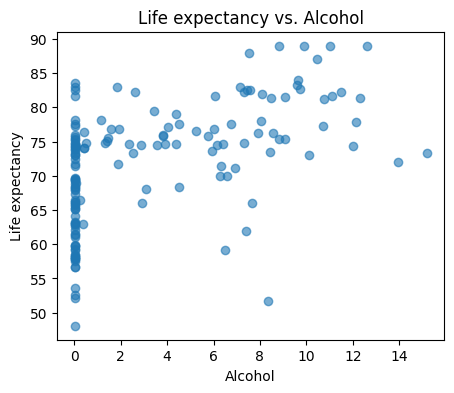

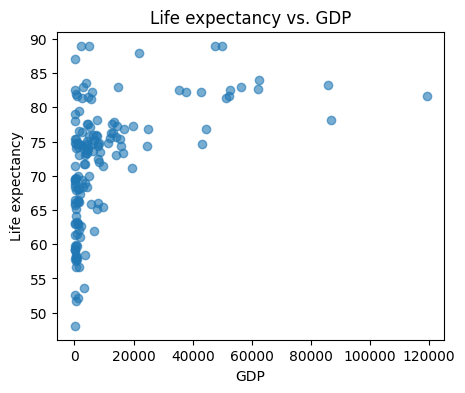

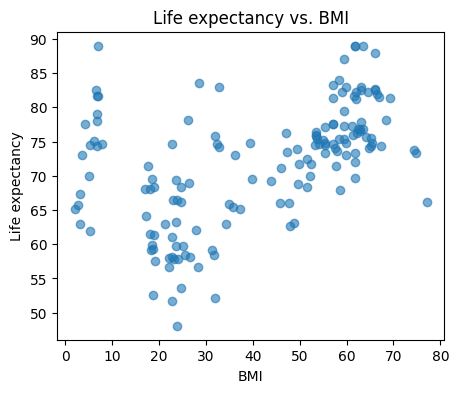

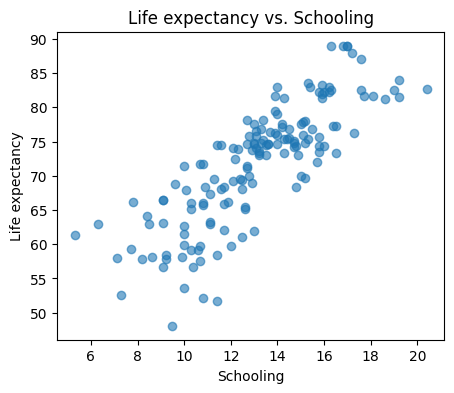

In [344]:
#Re-run predictor vs. response plots

response = cols[0]
predictors = cols[1:]
for col in predictors:
    plt.figure(figsize=(5,4))
    plt.scatter(data[col], data[response], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel(response)
    plt.title(f"{response} vs. {col}")
    plt.show()

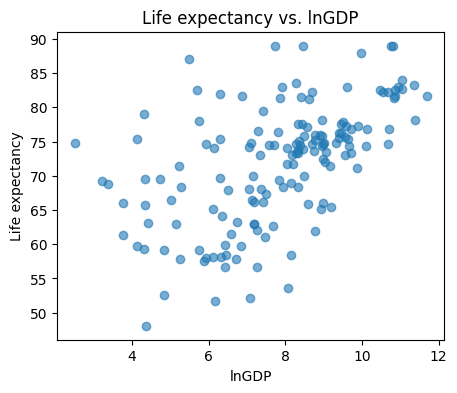

This looks much better.


In [345]:
#GDP looks to have a log relationship with life expectancy, so lets log transform the GDP predictor and reassess.
data["lnGDP"] = np.log(data["GDP"])
data
plt.figure(figsize=(5,4))
plt.scatter(data["lnGDP"], data["Life expectancy"], alpha=0.6)
plt.xlabel("lnGDP")
plt.ylabel("Life expectancy")
plt.title(f"{"Life expectancy"} vs. {"lnGDP"}")
plt.show()
print("This looks much better.")

In [346]:
#Create a linear model using statsmodels

#Clean pandas column names
def clean_name(col):
    return col.strip().replace(" ","_")

#Replace GDP with lnGDP in the predictors list
gdpindex = predictors.index("GDP") 
predictors[gdpindex] = "lnGDP"

data = data.rename(columns=clean_name)
model = smf.ols("Life_expectancy ~ Alcohol + lnGDP + BMI + Schooling + C(Status)", data = data).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     65.40
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.51e-35
Time:                        18:52:05   Log-Likelihood:                -454.96
No. Observations:                 152   AIC:                             921.9
Df Residuals:                     146   BIC:                             940.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  42.9100      3.122     13.744      0.000      36.740      49.080
C(Status)[T.Developing]    -2.2004      1.300     -1.693      0.093      -4.770       0.369
Alcohol                     0.0708      0.124      0.572      0.568      -0.174       0.315
lnGDP                       0.4079      0.254      1.606      0.110      -0.094       0.910
BMI                         0.0479      0.022      2.184      0.031       0.005       0.091
Schooling                   1.9300      0.227      8.512      0.000       1.482       2.378
==============================================================================
Omnibus:                        8.246   Durbin-Watson:                   2.371
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.281
Skew:                          -0.568   Prob(JB):                       0.0159
Kurtosis:                       3.131   Cond. No.                         396.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

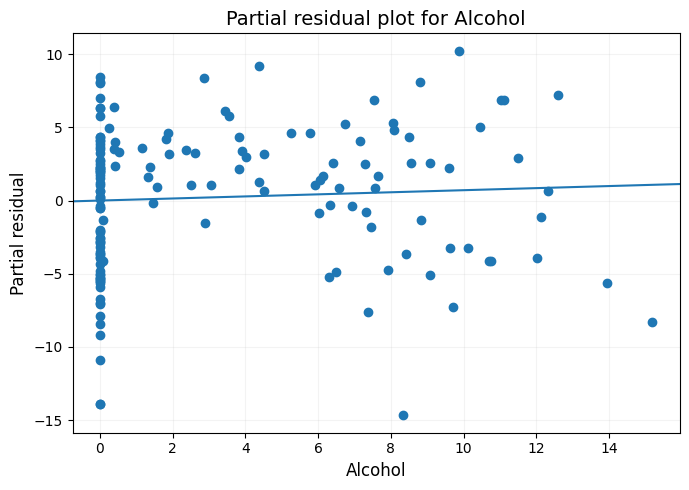

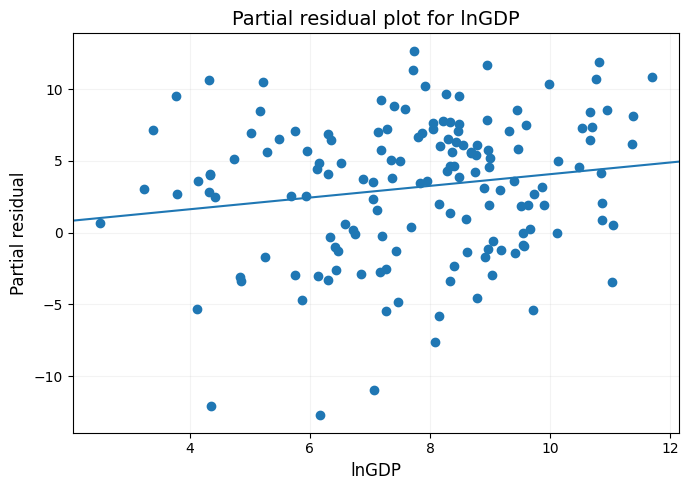

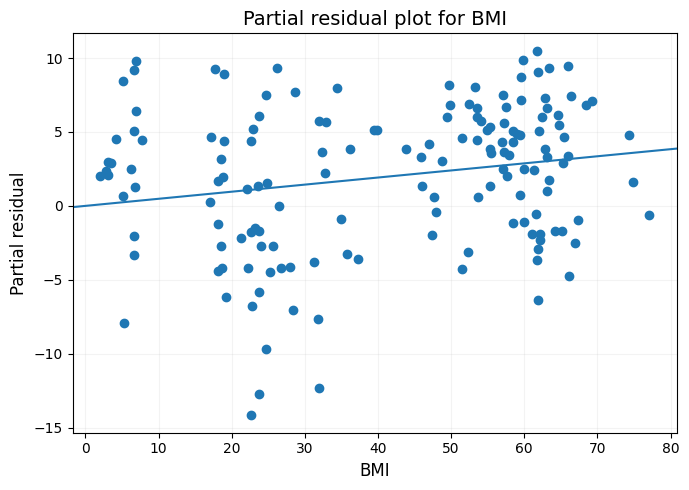

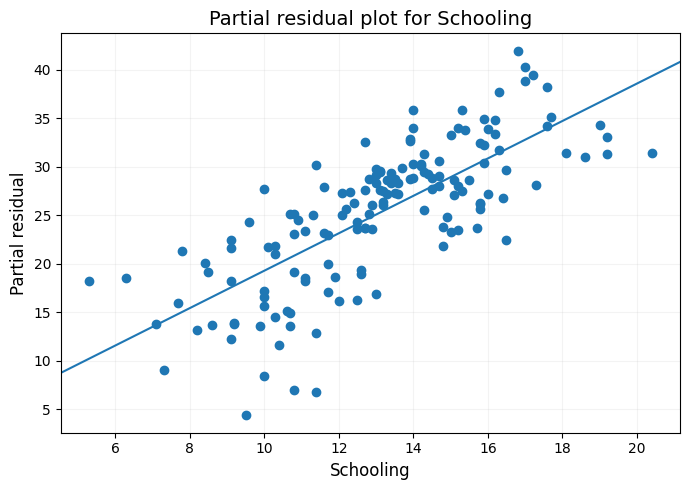

In [347]:
#Lets look at the partial residual plots to get a better idea of the effect of each predictor individually.

for predictor in predictors[1:]:
    fig, ax = plt.subplots(figsize=(7,5))
    sm.graphics.plot_ccpr(model, predictor, ax=ax)
    ax.set_title(f"Partial residual plot for {predictor}", fontsize=14)
    ax.set_xlabel(predictor, fontsize=12)
    ax.set_ylabel("Partial residual", fontsize=12)
    ax.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()

In [348]:
#The partial residual plot for alcohol consumption is being skewed by the countries that don't show any alcohol consumption at all.
#This could be because in the data collection process, countries that don't report alcohol consumption are defaulted
#to a value of zero, even when this might not really be the case. This would explain the wide range of residuals for
#only the 0 alcohol value.
#Since we have 2 "clusters" of points, alcohol = 0 and alcohol >0 , lets fit a new model with a categorical variable for whether 
#alcohol = 0 or not.
print("It looks like the default value for Alcohol = 0 is actually 0.01:")
print(data["Alcohol"].value_counts())

#Load new categorical variable for Alcohol = 0.
data["AlcoholZero"] = (data["Alcohol"] == 0.01).astype(int)



It looks like the default value for Alcohol = 0 is actually 0.01:
Alcohol
0.01    71
0.09     2
4.51     1
8.56     1
8.33     1
        ..
2.90     1
8.06     1
1.91     1
6.03     1
6.50     1
Name: count, Length: 81, dtype: int64


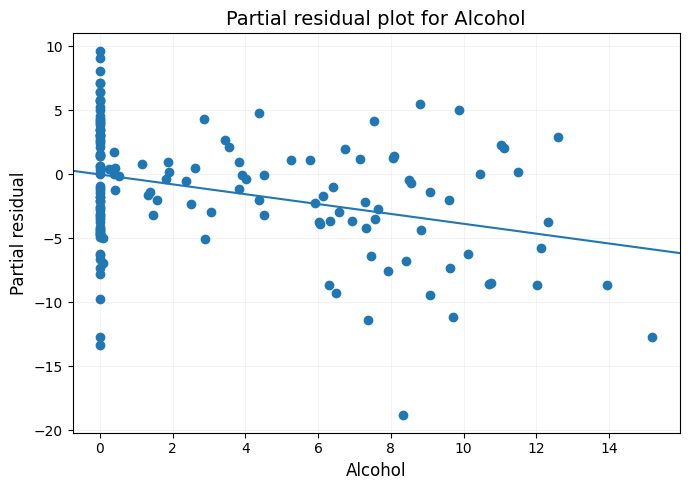

That looks much better. Now that the categorical variable explains the difference between
 Alcohol = 0 and Alcohol > 0, the resulting effect of Alcohol looks linear.



Model output:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     63.52
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           3.83e-38
Time:                        18:52:05   Log-Likelihood:                -446.34
No. Observations:                 152   AIC:                             906.7
Df Residuals:                     145   BIC:                             927.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  50.7190      3.503     14.480      0.000      43.796      57.642
C(Status)[T.Developing]    -3.7803      1.290     -2.931      0.004      -6.329      -1.232
Alcohol                    -0.3854      0.160     -2.402      0.018      -0.702      -0.068
AlcoholZero                -5.1203      1.228     -4.171      0.000      -7.547      -2.694
lnGDP                       0.2559      0.244      1.051      0.295      -0.225       0.737
BMI                         0.0393      0.021      1.878      0.062      -0.002       0.081
Schooling                   1.8467      0.216      8.553      0.000       1.420       2.273
==============================================================================
Omnibus:                        5.935   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.492
Skew:                          -0.415   Prob(JB):                       0.0642
Kurtosis:                       3.423   Cond. No.                         472.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [349]:
#Lets make the new model
model = smf.ols("Life_expectancy ~ Alcohol + AlcoholZero + lnGDP + BMI + Schooling + C(Status)", data = data).fit()

predictor = "Alcohol"
fig, ax = plt.subplots(figsize=(7,5))
sm.graphics.plot_ccpr(model, predictor, ax=ax)
ax.set_title(f"Partial residual plot for {predictor}", fontsize=14)
ax.set_xlabel(predictor, fontsize=12)
ax.set_ylabel("Partial residual", fontsize=12)
ax.grid(alpha=0.15)
plt.tight_layout()
plt.show()

print("That looks much better. Now that the categorical variable explains the difference between\n" \
" Alcohol = 0 and Alcohol > 0, the resulting effect of Alcohol looks linear.")

print("\n\n")

print("Model output:")
model.summary()

In [350]:
'''
=================
Old plotting code
=================


#Partial regression plots for the continuous predictors

def partial_regression_plot(model, data, predictor, fixed_status = "Developing"):
    #Create an x-axis grid for the selected predictor
    x_grid = np.linspace(data[predictor].min(), data[predictor].max(), 100)

    #Create a dataframe with all other predictors constant at their means
    df_pred = pd.DataFrame({
        "Alcohol": np.repeat(data["Alcohol"].mean(), 100),
        "lnGDP": np.repeat(data["lnGDP"].mean(), 100),
        "BMI": np.repeat(data["BMI"].mean(), 100),
        "Schooling": np.repeat(data["Schooling"].mean(), 100),
        "AlcoholZero": np.repeat(0, 100), #Assume the continuous case for alcohol
        "Status": np.repeat(fixed_status, 100) #Pick developing/developed status
    })

    #Replace the selected predictor with an x-axis grid
    df_pred[predictor] = x_grid

    #Create partial regression line
    y_hat = model.predict(df_pred)

    #Plot scatterplot first
    plt.figure(figsize=(6,4))
    plt.scatter(data[predictor], data["Life_expectancy"], alpha=0.5, label="Data")

    #Plot the line
    plt.plot(x_grid, y_hat, color="red", linewidth=2, label="Partial regression line")
    plt.xlabel(predictor)
    plt.ylabel("Life expectancy")
    plt.title(f"Life expectancy vs {predictor} (partial regression)")
    plt.legend()
    plt.show()

for predictor in predictors[1:]:
    partial_regression_plot(model, data, predictor)

'''



'\n=================\nOld plotting code\n=================\n\n\n#Partial regression plots for the continuous predictors\n\ndef partial_regression_plot(model, data, predictor, fixed_status = "Developing"):\n    #Create an x-axis grid for the selected predictor\n    x_grid = np.linspace(data[predictor].min(), data[predictor].max(), 100)\n\n    #Create a dataframe with all other predictors constant at their means\n    df_pred = pd.DataFrame({\n        "Alcohol": np.repeat(data["Alcohol"].mean(), 100),\n        "lnGDP": np.repeat(data["lnGDP"].mean(), 100),\n        "BMI": np.repeat(data["BMI"].mean(), 100),\n        "Schooling": np.repeat(data["Schooling"].mean(), 100),\n        "AlcoholZero": np.repeat(0, 100), #Assume the continuous case for alcohol\n        "Status": np.repeat(fixed_status, 100) #Pick developing/developed status\n    })\n\n    #Replace the selected predictor with an x-axis grid\n    df_pred[predictor] = x_grid\n\n    #Create partial regression line\n    y_hat = model.p

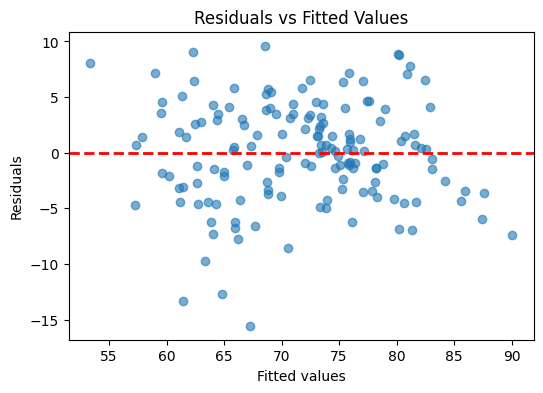

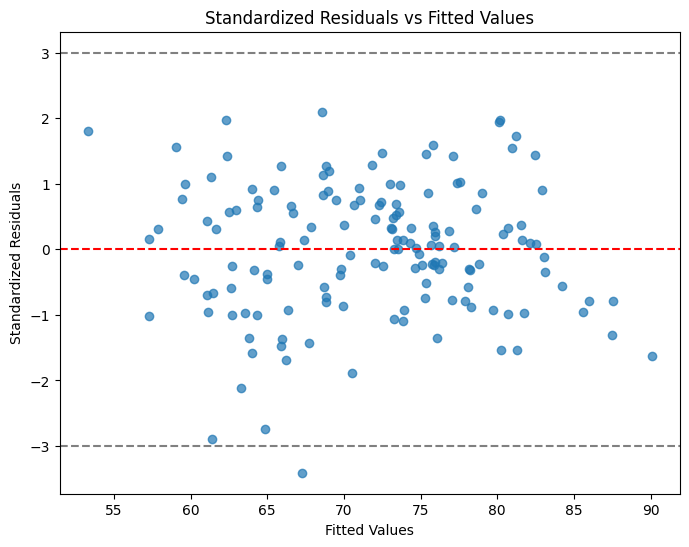

There is one point that lies more than 3 standard deviations from the mean life expectancy, 
but this is expected with this number of data points, and it doesn't look to be influential so we can leave it.


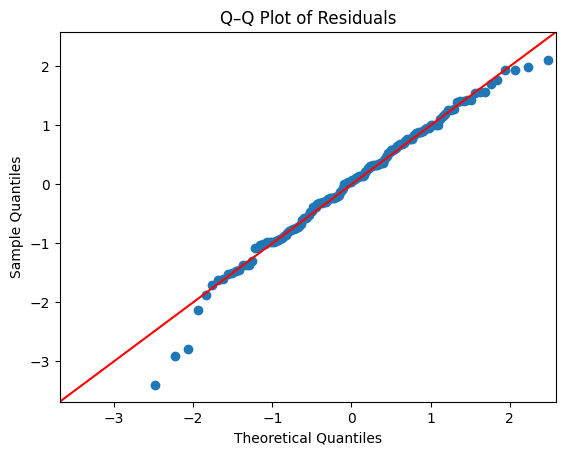

For the most part, this QQ plot looks very good, the left tail is a little heavy, 
but the distribution is approximately normal and our assumptions are valid.


In [351]:
#For final checks, lets look at a residual vs fitted values and QQ plot.

#Residual vs fitted plot
residuals = model.resid
fitted_values = model.fittedvalues
plt.figure(figsize=(6,4))
plt.scatter(fitted_values, residuals, alpha = 0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

#Standardized residuals
standardized_residuals = model.get_influence().resid_studentized_internal
plt.figure(figsize=(8,6))
plt.scatter(fitted_values, standardized_residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.axhline(3, color='grey', linestyle='--')
plt.axhline(-3, color='grey', linestyle='--')

plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.title("Standardized Residuals vs Fitted Values")
plt.show()
print("There is one point that lies more than 3 standard deviations from the mean life expectancy, \n" \
"but this is expected with this number of data points, and it doesn't look to be influential so we can leave it.")

#QQ plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q–Q Plot of Residuals")
plt.show()
print("For the most part, this QQ plot looks very good, the left tail is a little heavy, \n" \
"but the distribution is approximately normal and our assumptions are valid.")